## Import required libraries

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import pickle


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/supsaha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the dataset

In [135]:
df = pd.read_csv('spotify_millsongdata.csv')

In [136]:
df.shape

(57650, 4)

In [162]:
df.head(10)

,artist,song,text
12791,Metallica,Brandenburg Gate,i would cut leg tit when i think bori karloff ...
32478,Fall Out Boy,Lake Effect Kid,"sometim when i'm heaven i get forget earth, wo..."
28991,David Bowie,Lucy Can't Dance,luci i know go go oh luci look i'm now look go...
45877,Nina Simone,In The Dark,in dark it' i not sound ther' one sigh just be...
3224,Cliff Richard,Help It Along,"some fine day live together, give together. on..."
1470,Bing Crosby,On A Slow Boat To China,i'd like get slow boat china all alon get keep...
24244,Ariana Grande,You Don't Know Me,center attent they understand they understand ...
49395,Queen Adreena,Medicine Jar,my babi talk sleep i said wake she' good behav...
40040,Kenny Rogers,Ghost Of Another Man,he' live big old hous know built he' play babi...
21410,Whitesnake,The Deeper The Love,when i look back on everyth i'v done i know mu...


In [138]:
df.shape

(57650, 4)

In [139]:
df.isnull().sum()

artist    0
song      0
link      0
text      0
dtype: int64

In [140]:
df = df.drop('link', axis=1).reset_index(drop=True)

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   text    57650 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [142]:
df.columns

Index(['artist', 'song', 'text'], dtype='object')

In [143]:
df['text'][0]

"Look at her face, it's a wonderful face  \r\nAnd it means something special to me  \r\nLook at the way that she smiles when she sees me  \r\nHow lucky can one fellow be?  \r\n  \r\nShe's just my kind of girl, she makes me feel fine  \r\nWho could ever believe that she could be mine?  \r\nShe's just my kind of girl, without her I'm blue  \r\nAnd if she ever leaves me what could I do, what could I do?  \r\n  \r\nAnd when we go for a walk in the park  \r\nAnd she holds me and squeezes my hand  \r\nWe'll go on walking for hours and talking  \r\nAbout all the things that we plan  \r\n  \r\nShe's just my kind of girl, she makes me feel fine  \r\nWho could ever believe that she could be mine?  \r\nShe's just my kind of girl, without her I'm blue  \r\nAnd if she ever leaves me what could I do, what could I do?\r\n\r\n"

In [144]:
# Top artists and songs
top_artists = df['artist'].value_counts().head(10)
print("\nTop 10 Artists:")
print(top_artists)


Top 10 Artists:
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Cher                187
Alabama             187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [145]:
df = df.sample(5000)

In [146]:
df.shape

(5000, 3)

## Data cleaning and preprocessing

In [147]:
## To remove all the special characters and punctuation marks 
df['text'].str.lower().replace(r'[^\w\d\s]', '', regex=True)

12791    i would cut my legs and tits off  \r\nwhen i t...
32478    sometimes  \r\nwhen im in heaven  \r\ni get fo...
28991    lucy i know what youre going to going to do  \...
45877    in the dark  \r\nits just you and i  \r\nnot a...
3224     some fine day well live  \r\ntogether give tog...
                               ...                        
49660    its my party and ill cry if i want to  \r\ncry...
5689     yesterday just a dream i dont remember  \r\nto...
22903    arsenio chris rock  \r\nnow dont leave us hang...
29499    put it on  \r\nand dont say a word  \r\nput it...
18564    take a deep breath  \r\ncause it all starts no...
Name: text, Length: 5000, dtype: object

In [148]:
## To remove \n from the text and replace with the space
df['text'].str.lower().replace(r'\n', ' ', regex=True)

12791    i would cut my legs and tits off  \r when i th...
32478    sometimes  \r when i'm in heaven  \r i get for...
28991    lucy i know what you're going to going to do  ...
45877    in the dark  \r it's just you and i  \r not a ...
3224     some fine day we'll live  \r together, give to...
                               ...                        
49660    it's my party and i'll cry if i want to  \r cr...
5689     yesterday, just a dream i don't remember  \r t...
22903    arsenio (chris rock):  \r now don't leave us h...
29499    put it on  \r and don't say a word  \r put it ...
18564    take a deep breath  \r 'cause it all starts no...
Name: text, Length: 5000, dtype: object

In [149]:
df.tail(5)

,artist,song,text
49660,Quincy Jones,It's My Party,It's my party and I'll cry if I want to \r\nC...
5689,Everlast,Today,"Yesterday, just a dream I don't remember \r\n..."
22903,Adam Sandler,Girl,Arsenio (chris rock): \r\nNow don't leave us ...
29499,Depeche Mode,Blue Dress,Put it on \r\nAnd don't say a word \r\nPut i...
18564,Slayer,Flesh Storm,Take a deep breath \r\n'Cause it all starts n...


In [150]:
## Create a word Cloud
all_lyrics = " ".join(df['text'].dropna())
wc = WordCloud(width=800, height=400, background_color='white').generate(all_lyrics)

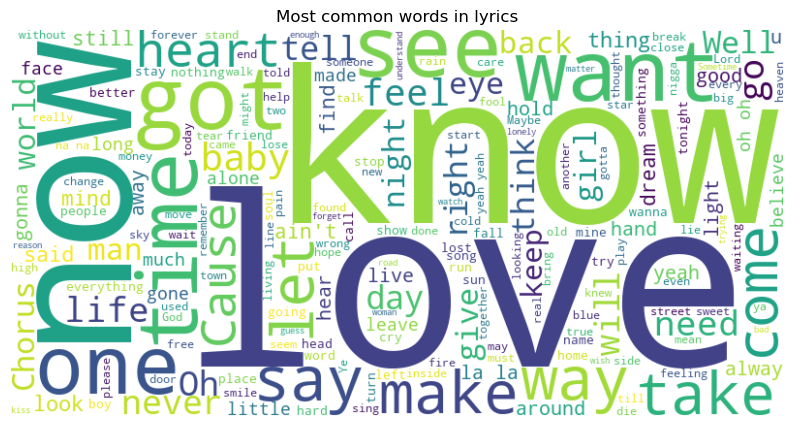

In [151]:
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in lyrics')
plt.show()

In [152]:
## Create a function for applying stemming
stemmer = PorterStemmer()
def tokenize_stem(text):
    words = []
    for word in text.split():
        if word not in stopwords.words('english'):
            words.append(stemmer.stem(word))
    return ' '.join(words)

In [153]:
df['text'] = df['text'].apply(func = tokenize_stem)

In [161]:
df.head()

,artist,song,text
12791,Metallica,Brandenburg Gate,i would cut leg tit when i think bori karloff ...
32478,Fall Out Boy,Lake Effect Kid,"sometim when i'm heaven i get forget earth, wo..."
28991,David Bowie,Lucy Can't Dance,luci i know go go oh luci look i'm now look go...
45877,Nina Simone,In The Dark,in dark it' i not sound ther' one sigh just be...
3224,Cliff Richard,Help It Along,"some fine day live together, give together. on..."


In [155]:
# Tf-Idf Feature Extraction
TfidfVectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = TfidfVectorizer.fit_transform(df['text'])

In [156]:
# Calculate similarity
similarity_score = cosine_similarity(tfidf_matrix)
similarity_score[0].shape


(5000,)

In [157]:
df[df['song'] == 'Two Blue Singing Stars' ].index

Index([], dtype='int64')

In [158]:
## Recommendation system
def recommend_song(song_name):
    idx = df[df['song']== song_name].index[0]
    distances = sorted(list(enumerate(similarity_score[idx])), reverse=True, key= lambda x: x[1])
    song = []
    for song_id in distances[1:5]:
        song.append(df.iloc[song_id[0]].song)
    return song

In [160]:
recommendations = recommend_song("Help It Along")
print(recommendations)

['Little Wonder', 'I Wonder If I Care As Much', "Can't Help Wondering Why", 'Me Without You']


In [ ]:
recommendations = recommend_song("In The Dark")
print(recommendations)

['Dealer', 'Let Love Down', 'Let Yourself Go', 'Let It Down']

## Save the model

In [168]:
# Save similarity matrix
with open('similarity.pkl', 'wb') as f:
    pickle.dump(similarity_score, f)

# Save dataframe
with open('df.pkl', 'wb') as f:
    pickle.dump(df, f)